# MDS THESIS
## Random Forest

### 0. Setup

In [1]:
# Install required packages
#!pip install scikit-learn
#%pip install -q pandas matplotlib numpy scikit-learn 
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     ---------- ----------------------------- 1.6/6.2 MB 9.2 MB/s eta 0:00:01
     ------------------------- -------------- 3.9/6.2 MB 10.5 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 11.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     -------------------------------------- 536.2/536.2 kB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB 13.6 MB/s eta 0:03:21
   ---------------------------------------- 0.0/2.7 GB 13.0 MB/s eta 0:03:29
   ---------------------------------------- 0.0/2.7 GB 13.2 MB/s eta 0:03:27
   ---------------------------------------- 0.0/2.7 GB 13.2 MB/s eta 0:03:26
   -----------------------------------

In [7]:
# Import packages 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
#to display matplotlib plots directly in the notebook
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import TimeSeriesSplit
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

### 0. Load data

In [8]:
# Import train
#train = pd.read_csv('../Data/train_test/train_df.csv')
train = pd.read_csv('Data/train_test/train_df.csv')

# Import test
#test = pd.read_csv('../Data/train_test/test_df.csv')
test = pd.read_csv('Data/train_test/test_df.csv')

In [31]:
# Load dataset
df = pd.read_csv("final_df.csv")

### 1. Visualize features

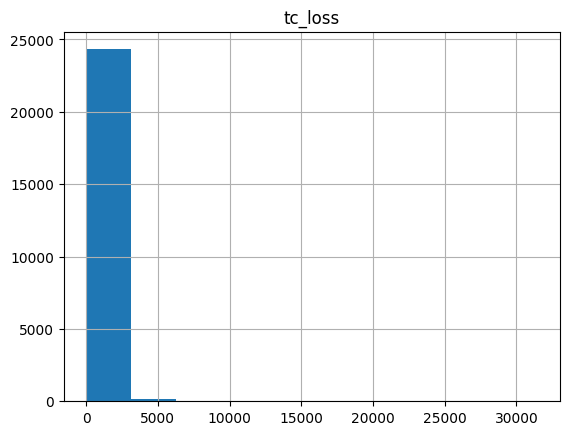

In [4]:
# Histporgram for each feature
viz = df[['tc_loss']]
viz.hist()
plt.show()

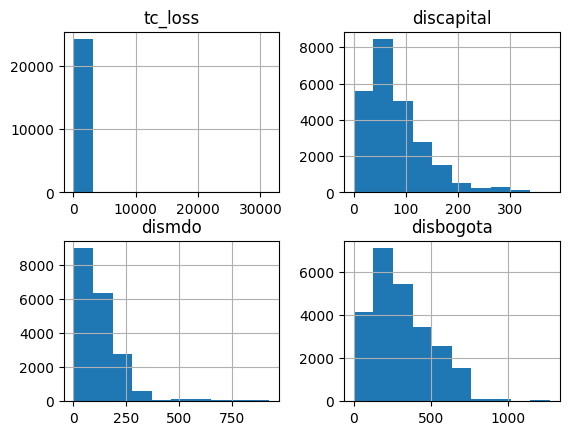

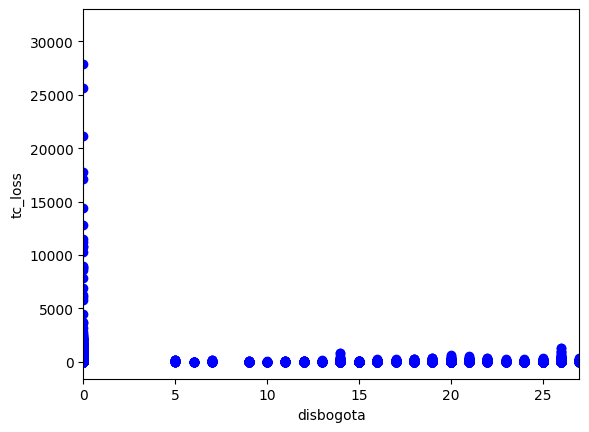

In [22]:
# Histporgram for each feature
viz = df[['tc_loss','discapital','dismdo','disbogota']]
viz.hist()
plt.show()

# Plot features vs Y
plt.scatter(df.discapital, df.tc_loss,  color='blue')
plt.xlabel("disbogota")
plt.ylabel("tc_loss")
plt.xlim(0,27)
plt.show()

### 2. Preprocess data

In [10]:
# y train and test
y_train = train['tc_loss_area']
y_test = test['tc_loss_area']

# Normalize output
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Convert to PyTorch tensors and send to GPU
#y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor(y_train, dtype=torch.float32)
#y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device)
y_tensor_test = torch.tensor(y_test, dtype=torch.float32)

In [32]:
# Convert year into string 
df["year"] = df["year"].astype(str).str.strip()

# Align missing values format
df["year"] = df["year"].replace(["", "nan", "None"], pd.NA)  # Converts problematic values to `pd.NA`

# Drop missig values
df = df.dropna(subset=["year"])  # Removes NaN values before conversion

# Convert "year" to float, then integer
df["year"] = df["year"].astype(float).astype(int)

# Convert "year" to datetime format
df["year"] = pd.to_datetime(df["year"], format="%Y")

# Check the result
print(df.dtypes)
print(df.head())

subnational1                         object
subnational2                         object
cluster_kmeans                        int64
codmpio                             float64
year                         datetime64[ns]
                                  ...      
vrf_peq_productor                   float64
vrf_victimas_conflicto_gp           float64
vrf_victimas_conflicto_mp           float64
vrf_victimas_conflicto_pp           float64
vrf_dept_dist_muni                  float64
Length: 1269, dtype: object
  subnational1      subnational2  cluster_kmeans  codmpio       year  tc_loss  \
0    ANTIOQUIA  VIGIA DEL FUERTE               5   5873.0 2001-01-01   15.000   
1    ANTIOQUIA  VIGIA DEL FUERTE               5   5873.0 2002-01-01   19.000   
2    ANTIOQUIA  VIGIA DEL FUERTE               5   5873.0 2003-01-01    2.000   
3    ANTIOQUIA  VIGIA DEL FUERTE               5   5873.0 2004-01-01   18.000   
4    ANTIOQUIA  VIGIA DEL FUERTE               5   5873.0 2005-01-01   13.375   

 

### 3. Create train and test datasets

In [ ]:
# Sort valuer by year
df = df.sort_values(by="year")

# Fill missing values with 0 
df.fillna(0, inplace=True)

# Split data into evaluation and working
df_eval = df[df['year'] >= '2019-01-01']
df_wr = df[df['year'] < '2019-01-01']

In [50]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical feature (municipality)
df["codmpio"] = LabelEncoder().fit_transform(df["codmpio"])

# Split data into training and test sets
X = df_wr.drop(columns=["tc_loss", "subnational1", "subnational2"])  # Drops only the target variable
y = df_wr["tc_loss"]

# Split data into evaluation set
eva_size = 0.3

### 4. Random Forest

In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Encode categorical feature (municipality)
df_wr["subnational2"] = LabelEncoder().fit_transform(df["subnational2"])


ValueError: Length of values (24495) does not match length of index (19170)

In [ ]:

# Define time series split (5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Store MAE scores for evaluation
mae_scores = []

# Perform time-series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    
    print(f"Train Size: {len(train_index)}, Test Size: {len(test_index)}, MAE: {mae:.2f}")

# Print average MAE across all folds
print(f"Average MAE: {np.mean(mae_scores):.2f}")



DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [53]:
print(X.dtypes)  # Check column types


cluster_kmeans                        int64
codmpio                             float64
year                         datetime64[ns]
ano_x                               float64
gandina                             float64
                                  ...      
vrf_peq_productor                   float64
vrf_victimas_conflicto_gp           float64
vrf_victimas_conflicto_mp           float64
vrf_victimas_conflicto_pp           float64
vrf_dept_dist_muni                  float64
Length: 1266, dtype: object
